In [1]:
import drjit as dr
import mitsuba as mi
import numpy as np

import os
import sys
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from utils.utils import image_to_bm, to_float, unidim_to_bm, rel_l1_loss, mse, LOSS_FNS

mi.set_variant('cuda_ad_rgb')

In [2]:
integrator = {
    'type': 'direct_reparam',
}

In [3]:
from mitsuba.scalar_rgb import Transform4f as T

NB_BUNNIES = 10

def reset_scene():
    scene_dict = {
        'type': 'scene',
        'integrator': integrator,
        'sensor':  {
            'type': 'perspective',
            'to_world': T.look_at(
                            origin=(0, 0, 2),
                            target=(0, 0, 0),
                            up=(0, 1, 0)
                        ),
            'fov': 60,
            'film': {
                'type': 'hdrfilm',
                'width': 64,
                'height': 64,
                'rfilter': { 'type': 'gaussian' },
                'sample_border': True
            },
        },
        'wall': {
            'type': 'obj',
            'filename': '../scenes/meshes/rectangle.obj',
            'to_world': T.translate([0, 0, -2]).scale(2.0),
            'face_normals': True,
            'bsdf': {
                'type': 'diffuse',
                'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
            }
        },
        'light': {
            'type': 'obj',
            'filename': '../scenes/meshes/sphere.obj',
            'emitter': {
                'type': 'area',
                'radiance': {'type': 'rgb', 'value': [1e3, 1e3, 1e3]}
            },
            'to_world': T.translate([2.5, 2.5, 7.0]).scale(0.25)
        }
    }

    # set numpy seed
    np.random.seed(0)
    for i in range(NB_BUNNIES):
        pos_x = np.random.uniform(-1.0, 1.0)
        pos_y = np.random.uniform(-1.0, 1.0)
        rot = np.random.uniform(0.0, 360.0)
        scene_dict[f'bunny{i}'] = {
            'type': 'ply',
            'filename': '../scenes/meshes/bunny.ply',
            'to_world': T.translate([pos_x,pos_y,0]).rotate([0, 1, 0], rot).scale(5.0 / np.sqrt(NB_BUNNIES)),
            'bsdf': {
                'type': 'diffuse',
                'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) },
            },
        }

    return mi.load_dict(scene_dict)

In [16]:
scene = reset_scene()
img_ref = mi.render(scene, seed=0, spp=1024)

mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [17]:
params = mi.traverse(scene)
initial_vertex_positions = [dr.unravel(mi.Point3f, params[f'bunny{i}.vertex_positions']) for i in range(NB_BUNNIES)]

In [6]:
def update_scene(params, trans_x, trans_y, angle):
    for i in range(NB_BUNNIES):
        trafo = mi.Transform4f.translate([trans_x[i], trans_y[i], 0.0]).rotate([0, 1, 0], angle[i] * 180.0)
        params[f'bunny{i}.vertex_positions'] = dr.ravel(trafo @ initial_vertex_positions[i])
    params.update()

def apply_transformation(params, opt):
    trans_x, trans_y, angle = [], [], []
    for i in range(NB_BUNNIES):
        opt[f'trans{i}'] = dr.clamp(opt[f'trans{i}'], -0.5, 0.5)
        opt[f'angle{i}'] = dr.clamp(opt[f'angle{i}'], -1.0, 1.0)
        trans_x.append(opt[f'trans{i}'].x)
        trans_y.append(opt[f'trans{i}'].y)
        angle.append(opt[f'angle{i}'])
    return update_scene(params, trans_x, trans_y, angle)

In [28]:
scene = reset_scene()
params = mi.traverse(scene)

opt = mi.ad.Adam(lr=0.025)
for i in range(NB_BUNNIES):
    opt[f'trans{i}'] = mi.Point2f(0.3, -0.3)
    opt[f'angle{i}'] = mi.Float(0.25)
apply_transformation(params, opt)
img_init = mi.render(scene, seed=0, spp=1024)
mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [29]:
iteration_count = 10
spp = 16

In [32]:
scene = reset_scene()
params = mi.traverse(scene)

opt = mi.ad.Adam(lr=0.025)
for i in range(NB_BUNNIES):
    opt[f'trans{i}'] = mi.Point2f(0.3, -0.3)
    opt[f'angle{i}'] = mi.Float(0.25)

loss_hist = []
for it in range(iteration_count):
    # Apply the mesh transformation
    apply_transformation(params, opt)

    # Perform a differentiable rendering
    img = mi.render(scene, params, seed=it, spp=spp)

    # Evaluate the objective function
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    loss_hist.append(loss)
    print(f"Iteration {it:02d}: error={loss[0]:6f}", end='\r')

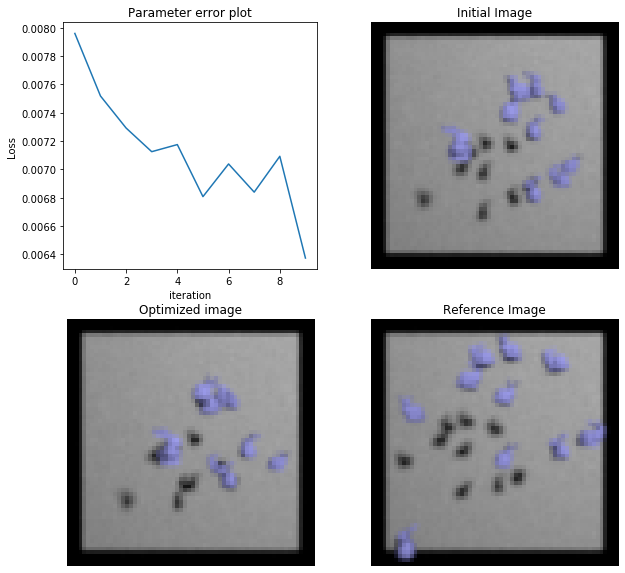

In [33]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

# Global optimization

In [61]:
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
import numpy as np

class BunniesProblem(Problem):
    def __init__(self, ref_img, loss_fn, spp):
        self.ref_img = ref_img
        self.loss_fn = loss_fn
        self.spp = spp
        super().__init__(n_var=3*NB_BUNNIES, n_obj=1, n_constr=0, xl=-1.0, xu=1.0)
    
    def _array_to_params(self, values):
        trans_x, trans_y, angle = [], [], []
        for j in range(NB_BUNNIES):
            trans_x.append(to_float(values[3*j]))
            trans_y.append(to_float(values[3*j+1]))
            angle.append(to_float(values[3*j+2]))
        return trans_x, trans_y, angle

    def _evaluate(self, x, out, *args, **kwargs):
        nb_samples = x.shape[0]
        out["F"] = np.array([0.0]*nb_samples)
        for i in range(nb_samples):
            scene = reset_scene()
            params = mi.traverse(scene)
            trans_x, trans_y, angle = self._array_to_params(x[i])
            update_scene(params, trans_x, trans_y, angle)
            image = mi.render(scene, params, seed=i, spp=self.spp)
            loss = to_float(self.loss_fn(image, self.ref_img))
            out["F"][i] = loss
    
    def show_res(self, x, spp=None):
        if spp is None:
            spp = self.spp
        scene = reset_scene()
        params = mi.traverse(scene)
        trans_x, trans_y, angle = self._array_to_params(x)
        update_scene(params, trans_x, trans_y, angle)
        image = mi.render(scene, params, seed=0, spp=spp)
        return image_to_bm(image)

In [62]:
from pymoo.algorithms.soo.nonconvex.ga import GA

problem = BunniesProblem(img_ref, mse, 16)
algorithm = GA(pop_size=20, eliminate_duplicates=True)
res_ga = minimize(problem, algorithm, ('n_gen', 15), seed=0, verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 |  0.0078718404 |  0.0066044843
     2 |       40 |  0.0071891952 |  0.0065875771
     3 |       60 |  0.0069321877 |  0.0065420186
     4 |       80 |  0.0067413991 |  0.0060952147
     5 |      100 |  0.0065668643 |  0.0060952147
     6 |      120 |  0.0064177372 |  0.0060087829
     7 |      140 |  0.0063003528 |  0.0059169214
     8 |      160 |  0.0062247067 |  0.0059169214
     9 |      180 |  0.0061473538 |  0.0059169214
    10 |      200 |  0.0060855899 |  0.0058731372
    11 |      220 |  0.0060692700 |  0.0058731372
    12 |      240 |  0.0060263498 |  0.0056761093
    13 |      260 |  0.0059969376 |  0.0056761093
    14 |      280 |  0.0059747854 |  0.0056761093
    15 |      300 |  0.0059395704 |  0.0056761093


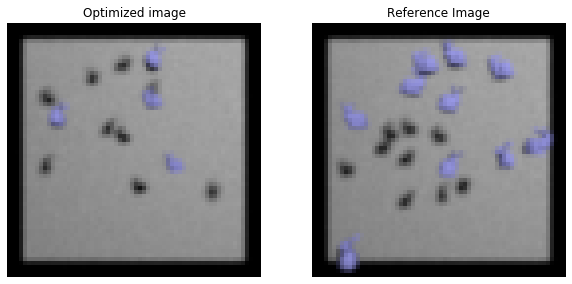

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].imshow(problem.show_res(res_ga.X, spp=1024))
axs[0].axis('off')
axs[0].set_title('Optimized image')

axs[1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1].axis('off')
axs[1].set_title('Reference Image');

## Global optimization + gradient descent - handmade algorithm

In [64]:
def cross_pair(a, b, cross_rate=0.5):
    nb_cross = int(cross_rate * a.shape[0])
    cross_points = list(np.random.choice(a.shape[0], nb_cross, replace=False))
    a, b = np.array(a), np.array(b)
    a[cross_points, ...], b[cross_points, ...] = b[cross_points, ...], a[cross_points, ...]
    return a, b

def mutate(a, mut_rate=0.1):
    if isinstance(a, dict):
        return {key: mutate(val, mut_rate) for (key, val) in a.items()}
    else:
        return np.clip(np.array(a) + np.random.normal(0, mut_rate, a.shape), 0, 1)

In [65]:
from pymoo.operators.sampling.rnd import FloatRandomSampling

def ga_opt(problem: Problem, pop_size = 10, selection_rate=0.3, mut_rate=0.03, nb_gen = 10, nb_grad_iter = 10, spp=32):
    best_image_gen = []
    best_params_gen = []

    sampling = FloatRandomSampling()
    param_values = sampling(problem, pop_size).get("X")

    for gen in range(nb_gen):
        print(f"Generation {gen+1}/{nb_gen}")

        losses = []
        new_param_values = []
        img_end = []
        for i, value in enumerate(param_values):
            opt = mi.ad.Adam(lr=0.025)
            for j in range(NB_BUNNIES):
                opt[f'trans{j}'] = mi.Point2f(value[3*j], value[3*j+1])
                opt[f'angle{j}'] = mi.Float(value[3*j+2])
            scene = reset_scene()
            params = mi.traverse(scene)
            
            for it in range(nb_grad_iter):
                print(f"Sample {i+1}/{pop_size}\tIteration {it+1}/{nb_grad_iter}", end='\r')
                apply_transformation(params, opt)
                img = mi.render(scene, params, seed=i*nb_grad_iter+it, spp=spp)
                loss = dr.sum(dr.sqr(img - img_ref)) / len(img)
                dr.backward(loss)
                opt.step()
            losses.append(to_float(loss))
            values = []
            for j in range(NB_BUNNIES):
                values.append(to_float(opt[f'trans{j}'].x))
                values.append(to_float(opt[f'trans{j}'].y))
                values.append(to_float(opt[f'angle{j}']))
            new_param_values.append(values)
            img_end.append(img)
        print()


        # handmade genetic algorithm to select the best samples for the next generation
        losses = np.array(losses)
        param_values = np.array(new_param_values)
        idx = np.argsort(losses)

        # print best loss
        print(f"Best loss: {losses[idx[0]]}")

        best_image_gen.append(image_to_bm(img_end[idx[0]]))

        # select the best samples for the next generation and cross them + mutate them
        best_values = [param_values[i] for i in idx[:max(int(pop_size*selection_rate), 1)]]
        new_param_values = []
        for i in range(pop_size):
            a = best_values[np.random.randint(len(best_values))]
            b = best_values[np.random.randint(len(best_values))]
            a, b = cross_pair(a, b)
            a = mutate(a, mut_rate)
            new_param_values.append(a)
        param_values = new_param_values
    
    return best_image_gen

res = ga_opt(problem, pop_size=10, selection_rate=0.3, mut_rate=0.03, nb_gen=10, nb_grad_iter=3, spp=16)

Generation 1/10
Sample 10/10	Iteration 3/3
Best loss: 0.007137408014386892
Generation 2/10
Sample 10/10	Iteration 3/3
Best loss: 0.00602528965100646
Generation 3/10
Sample 10/10	Iteration 3/3
Best loss: 0.005548412911593914
Generation 4/10
Sample 10/10	Iteration 3/3
Best loss: 0.005136236548423767
Generation 5/10
Sample 10/10	Iteration 3/3
Best loss: 0.0048097120597958565
Generation 6/10
Sample 10/10	Iteration 3/3
Best loss: 0.004966997541487217
Generation 7/10
Sample 10/10	Iteration 3/3
Best loss: 0.004633690230548382
Generation 8/10
Sample 10/10	Iteration 3/3
Best loss: 0.004756170324981213
Generation 9/10
Sample 10/10	Iteration 3/3
Best loss: 0.0047554681077599525
Generation 10/10
Sample 10/10	Iteration 3/3
Best loss: 0.004738958552479744


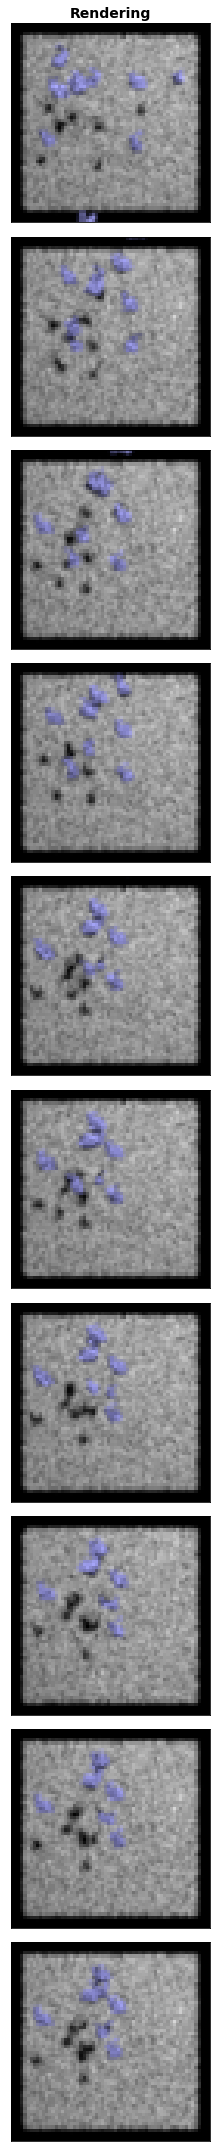

In [66]:
def plot(
    images_bm, size_factor=3
):
    fig, ax = plt.subplots(
        ncols=1,
        nrows=len(images_bm),
        figsize=(8, size_factor * len(images_bm)),
        squeeze=False,
    )
    for i, img in enumerate(images_bm):
        ax[i, 0].imshow(img, vmin=0, vmax=1)
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
    ax[0, 0].set_title("Rendering", weight="bold", size=14)
    plt.tight_layout()
    plt.show()

plot(res)

In [67]:
mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [21]:
res = ga_opt(problem, pop_size=10, selection_rate=0.3, mut_rate=0.03, nb_gen=30, nb_grad_iter=10, spp=16)

Generation 1/30
Sample 10/10	Iteration 10/10
Best loss: 0.006468500476330519
Generation 2/30
Sample 10/10	Iteration 10/10
Best loss: 0.005130001809448004
Generation 3/30
Sample 10/10	Iteration 10/10
Best loss: 0.004929920192807913
Generation 4/30
Sample 10/10	Iteration 10/10
Best loss: 0.004712327383458614
Generation 5/30
Sample 10/10	Iteration 10/10
Best loss: 0.00439071049913764
Generation 6/30
Sample 10/10	Iteration 10/10
Best loss: 0.004512347746640444
Generation 7/30
Sample 10/10	Iteration 10/10
Best loss: 0.004518704488873482
Generation 8/30
Sample 10/10	Iteration 10/10
Best loss: 0.004486782476305962
Generation 9/30
Sample 10/10	Iteration 10/10
Best loss: 0.004554065875709057
Generation 10/30
Sample 10/10	Iteration 10/10
Best loss: 0.0043709175661206245
Generation 11/30
Sample 10/10	Iteration 10/10
Best loss: 0.004155587404966354
Generation 12/30
Sample 10/10	Iteration 10/10
Best loss: 0.004367678426206112
Generation 13/30
Sample 10/10	Iteration 10/10
Best loss: 0.00443388661369

In [22]:
res = ga_opt(problem, pop_size=30, selection_rate=0.3, mut_rate=0.03, nb_gen=10, nb_grad_iter=10, spp=16)

Generation 1/10
Sample 30/30	Iteration 10/10
Best loss: 0.006340980529785156
Generation 2/10
Sample 30/30	Iteration 10/10
Best loss: 0.004948361776769161
Generation 3/10
Sample 30/30	Iteration 10/10
Best loss: 0.004571243189275265
Generation 4/10
Sample 30/30	Iteration 10/10
Best loss: 0.004312808159738779
Generation 5/10
Sample 30/30	Iteration 10/10
Best loss: 0.0043526566587388515
Generation 6/10
Sample 30/30	Iteration 10/10
Best loss: 0.0038362094201147556
Generation 7/10
Sample 30/30	Iteration 10/10
Best loss: 0.003796359058469534
Generation 8/10
Sample 30/30	Iteration 10/10
Best loss: 0.003492375835776329
Generation 9/10
Sample 30/30	Iteration 10/10
Best loss: 0.0032289880327880383
Generation 10/10
Sample 30/30	Iteration 10/10
Best loss: 0.0030695456080138683


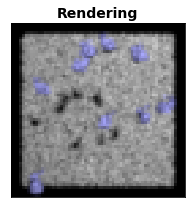

In [23]:
plot([res[-1]])

In [24]:
mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [9]:
from utils.global_opt import GlobalOptGrad, IterationStoppingCriteria, NotImprovingStoppingCriteria

In [10]:
class BunniesGlobalOpt(GlobalOptGrad):
    def __init__(self):
        super().__init__(n_var=3*NB_BUNNIES, xl=-1.0, xu=1.0)

    def set_params_from_vector(self, params, vector):
        for i in range(NB_BUNNIES):
            params[f'trans{i}'] = mi.Point2f(vector[3*i], vector[3*i+1])
            params[f'angle{i}'] = mi.Float(vector[3*i+2])

    def set_vector_from_params(self, params, vector):
        for j in range(NB_BUNNIES):
            vector[3*j] = to_float(params[f'trans{j}'].x)
            vector[3*j+1] = to_float(params[f'trans{j}'].y)
            vector[3*j+2] = to_float(params[f'angle{j}'])

    def apply_transformations(self, scene_params, params):
        apply_transformation(scene_params, params)

    def initialize_scene(self):
        scene = reset_scene()
        params = mi.traverse(scene)
        return scene, params

In [11]:
global_opt_bunnies = BunniesGlobalOpt()
loss_fn = lambda img: mse(img, img_ref)

In [12]:
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.de import DE

In [15]:
res_ga, losses_ga = global_opt_bunnies.run(
    GA(pop_size=10, eliminate_duplicates=True),
    loss_fn,
    n_gen=10,
    grad_descent_stopping_criteria=IterationStoppingCriteria(max_iter=3),
    lr=0.025,
    spp=spp,
    seed=0,
    verbose=True,
)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



[Gen. 10/10 Ind. 10/10	Best loss: 0.005654	Nb renderings: 201: 100%|██████████| 10/10 [01:52<00:00, 11.30s/it]


In [13]:
res_ga, losses_ga = global_opt_bunnies.run(
    GA(pop_size=10, eliminate_duplicates=True),
    loss_fn,
    n_gen=10,
    grad_descent_stopping_criteria=NotImprovingStoppingCriteria(max_iter=5, eps=0.0),
    lr=0.025,
    spp=spp,
    seed=0,
    verbose=True,
)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



[Gen. 10/10 Ind. 10/10	Best loss: 0.005414	Nb renderings: 238: 100%|██████████| 10/10 [01:31<00:00,  9.10s/it]


In [32]:
res_cmaes, losses_cmaes = global_opt_bunnies.run(
    CMAES(),
    loss_fn,
    n_gen=10,
    nb_grad_iter=3,
    lr=0.025,
    spp=spp,
    seed=0,
    verbose=True,
)

[Gen. 10/10 Ind. 14/14 It. 3/3]	Best loss: 0.005607	Nb renderings: 582: 100%|██████████| 10/10 [05:46<00:00, 34.63s/it]

hash 0.005607040598988533


In [33]:
res_de, losses_de = global_opt_bunnies.run(
    DE(pop_size=10),
    loss_fn,
    n_gen=10,
    nb_grad_iter=3,
    lr=0.025,
    spp=spp,
    seed=0,
    verbose=True,
)

[Gen. 10/10 Ind. 10/10 It. 3/3]	Best loss: 0.005617	Nb renderings: 398: 100%|██████████| 10/10 [04:11<00:00, 25.14s/it]

hash 0.005617309361696243


In [34]:
res_pso, losses_pso = global_opt_bunnies.run(
    PSO(pop_size=10),
    loss_fn,
    n_gen=10,
    nb_grad_iter=3,
    lr=0.025,
    spp=spp,
    seed=0,
    verbose=True,
)

[Gen. 10/10 Ind. 10/10 It. 3/3]	Best loss: 0.005209	Nb renderings: 398: 100%|██████████| 10/10 [04:26<00:00, 26.60s/it]

hash 0.0052086892537772655


In [69]:
res_ga2, losses_ga2 = global_opt_bunnies.run(
    GA(pop_size=30, eliminate_duplicates=True),
    loss_fn,
    n_gen=10,
    nb_grad_iter=10,
    lr=0.025,
    spp=spp,
    seed=42,
    verbose=True,
)

[Gen. 5/10 Ind. 13/30 It. 3/11]	Best loss: 0.005110	Nb renderings: 1454:  40%|████      | 4/10 [31:50<47:45, 477.52s/it] 


KeyboardInterrupt: 

In [53]:
res_ga2, losses_ga2 = global_opt_bunnies.run(
    GA(pop_size=30, eliminate_duplicates=True),
    loss_fn,
    n_gen=10,
    nb_grad_iter=0,
    lr=0.025,
    spp=spp,
    seed=0,
    verbose=True,
)

[Gen. 10/10 Ind. 30/30 It. 1/1]	Best loss: 0.005509	Nb renderings: 299: 100%|██████████| 10/10 [01:51<00:00, 11.20s/it]


In [54]:
res_ga2, losses_ga2 = global_opt_bunnies.run(
    GA(pop_size=20, eliminate_duplicates=True),
    loss_fn,
    n_gen=15,
    nb_grad_iter=0,
    lr=0.025,
    spp=spp,
    seed=0,
    verbose=True,
)

[Gen. 15/15 Ind. 20/20 It. 1/1]	Best loss: 0.005892	Nb renderings: 299: 100%|██████████| 15/15 [02:57<00:00, 11.81s/it]


In [55]:
res_ga2, losses_ga2 = global_opt_bunnies.run(
    CMAES(),
    loss_fn,
    n_gen=15,
    nb_grad_iter=0,
    lr=0.025,
    spp=spp,
    seed=0,
    verbose=True,
)

[Gen. 15/15 Ind. 14/14 It. 1/1]	Best loss: 0.005853	Nb renderings: 215: 100%|██████████| 15/15 [01:25<00:00,  5.69s/it]
